In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

from dark import getDarkChannel
from dark import getAtmosphereLight
from dark import getAtmosphericScatteringModel
from morphology import getMinimalChannel
from morphology import getMorphologicalTransmissionMap

In [2]:
def dehazeMorphological(I, s1, s2, g):
    windows = 15

    darkChannel = getDarkChannel(I, windows)
    atmosphereLight = getAtmosphereLight(I, darkChannel)

    imageNormalize = I / atmosphereLight
    imageNormalize = cv.normalize(imageNormalize, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    minimalChannel = getMinimalChannel(imageNormalize)
    tHat = getMorphologicalTransmissionMap(minimalChannel, s1, s2, g)

    J = getAtmosphericScatteringModel(I, tHat, atmosphereLight)
    J = cv.normalize(J, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

    return J

In [3]:
truth = cv.imread('./images/clear.jpg')
truth = cv.cvtColor(truth, cv.COLOR_BGR2RGB)
truth = cv.resize(truth, (600, 400))

haze = cv.imread('./images/haze.jpg')
haze = cv.cvtColor(haze, cv.COLOR_BGR2RGB)
haze = cv.resize(haze, (600, 400))
haze = haze / 255

s1, s2, g = 15, 42, 37
clear = dehazeMorphological(haze, s1, s2, g)

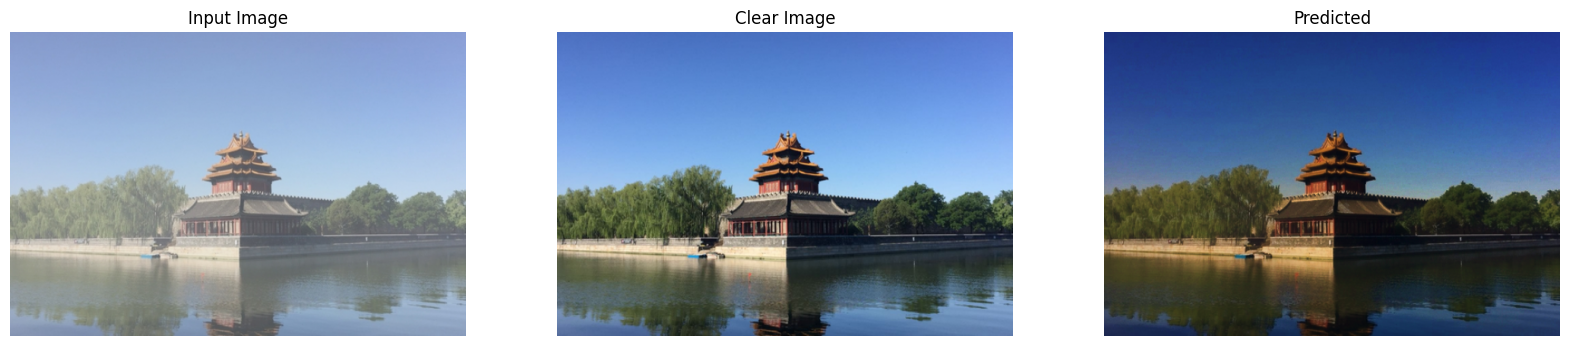

In [4]:
fig = plt.figure(figsize=(20, 7))
rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
plt.imshow(haze, cmap='gray')
plt.axis('off')
plt.title("Input Image")


fig.add_subplot(rows, columns, 2)
plt.imshow(truth)
plt.axis('off')
plt.title("Clear Image")

fig.add_subplot(rows, columns, 3)
plt.imshow(clear)
plt.axis('off')
plt.title("Predicted")


plt.show()